In [110]:
fundos = {
    "C0000463698" : "Trigono Delphos",         
    "C0000570494" : "BB TD Pre",
    "C0000570516" : "BB TD Infl",
    "C0000570524" : "BB TD Infl Curta",
    "C0000496121" : "BB FX Bonds",
    "C0000207098" : "BB TD Selic",
    "C0000457371" : "BB High",
    "C0000420530" : "Artesanal RF",
    "C0000377856" : "Mag Cash RF",
    "C0000422991" : "Ouro Preto Real RF",
    "C0000337031" : "Western SP500 FIM",
    "C0000679909" : "V8 L&S"
}


In [111]:
import time
import pandas as pd
import numpy as np

from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.covariance import LedoitWolf
from scipy.cluster.hierarchy import linkage, leaves_list
from scipy.spatial.distance import squareform


# =========================================
# Selenium Setup
# =========================================
options = webdriver.ChromeOptions()
options.add_argument("--headless")
options.add_argument("--disable-gpu")

driver = webdriver.Chrome(
    service=Service(ChromeDriverManager().install()),
    options=options
)

def to_float(series):

    s = series.astype(str)

    if s.str.contains(",").any():
        # padrão BR
        s = s.str.replace(".", "", regex=False)
        s = s.str.replace(",", ".", regex=False)

    s = s.str.replace("R$", "", regex=False)
    s = s.str.strip()

    return pd.to_numeric(s, errors="coerce")


# =========================================
#  Função scraping tabela
# =========================================
def baixar_fundo(codigo):

    url = f"https://data.anbima.com.br/fundos/{codigo}/dados-periodicos"
    print("Scraping", codigo)

    driver.get(url)
    time.sleep(6)

    try:
        table = driver.find_element(By.TAG_NAME, "table")
        rows = table.find_elements(By.TAG_NAME, "tr")
    except:
        print("Tabela não encontrada:", codigo)
        return None

    dados = []

    for r in rows[1:]:
        cols = r.find_elements(By.TAG_NAME, "td")

        if len(cols) >= 3:

            data = cols[0].text.strip()
            cota = cols[2].text.strip()

            dados.append([data, cota])

    if len(dados) == 0:
        return None

    df = pd.DataFrame(dados, columns=["data", fundos[codigo]])

    df["data"] = pd.to_datetime(df["data"], dayfirst=True)

    df[fundos[codigo]] = to_float(df[fundos[codigo]])
  
    
    return df.set_index("data")


In [112]:
# =========================================
#  Baixar todos fundos
# =========================================
dfs = []

for cod in fundos.keys():
    d = baixar_fundo(cod)
    if d is not None:
        dfs.append(d)

driver.quit()

# merge
df_cotas = pd.concat(dfs, axis=1)#.sort_index()

print("\nCotas:")
print(df_cotas.tail())



Scraping C0000463698
Scraping C0000570494
Scraping C0000570516
Scraping C0000570524
Scraping C0000496121
Scraping C0000207098
Scraping C0000457371
Scraping C0000420530
Scraping C0000377856
Scraping C0000422991
Scraping C0000337031
Scraping C0000679909

Cotas:
            Trigono Delphos  BB TD Pre  BB TD Infl  BB TD Infl Curta  \
data                                                                   
2026-02-02         2.709873   1.496637    1.333540          1.518136   
2026-02-03         2.735664   1.499450    1.333906          1.520191   
2026-02-04         2.680639   1.498088    1.332485          1.520138   
2026-02-05         2.685014   1.499237    1.332858          1.521211   
2026-02-06              NaN        NaN         NaN               NaN   

            BB FX Bonds  BB TD Selic   BB High  Artesanal RF  Mag Cash RF  \
data                                                                        
2026-02-02     1.569762    10.344452  1.954325      2.399804     3.024665   
2026

In [113]:
# ========================================
#  Retornos
# =========================================
retornos = (
    df_cotas
    .pct_change(fill_method=None)
    .dropna(how="any")
)

# retornos

In [114]:
# =========================================
#  Covariância ROBUSTA
# A covariância robusta de Ledoit-Wolf é um 
# método estatístico que melhora a estimativa 
# da matriz de covariância, especialmente quando 
# você tem:
# Poucos dados em relação ao número de ativos
# Ruído nos dados
# Instabilidade na matriz de covariância amostral
# =========================================
lw = LedoitWolf().fit(retornos.values)

cov_robusta = pd.DataFrame(
    lw.covariance_,
    index=retornos.columns,
    columns=retornos.columns
)

# Calcular a matriz de correlação a partir da covariância
std_dev = np.sqrt(np.diag(cov_robusta))
corr_robusta = cov_robusta / np.outer(std_dev, std_dev)
#  Garantir que a diagonal seja exatamente 1.0
np.fill_diagonal(corr_robusta.values, 1.0)


In [115]:
# Reordenamento hierárquico 
# Converte correlação em distância
dist_robusta = 1 - corr_robusta
# Clustering hierárquico. squareform() converte a matriz de distância para vetor condensado. linkage() agrupa os ativos usando método "average" (UPGMA)
link_robusta = linkage(squareform(dist_robusta), method="average")
# Extrai a ordem ótima das folhas do dendrograma
ordem_robusta = leaves_list(link_robusta)
# Reordena a matriz de correlação
corr_robusta_ord = corr_robusta.iloc[ordem_robusta, ordem_robusta]


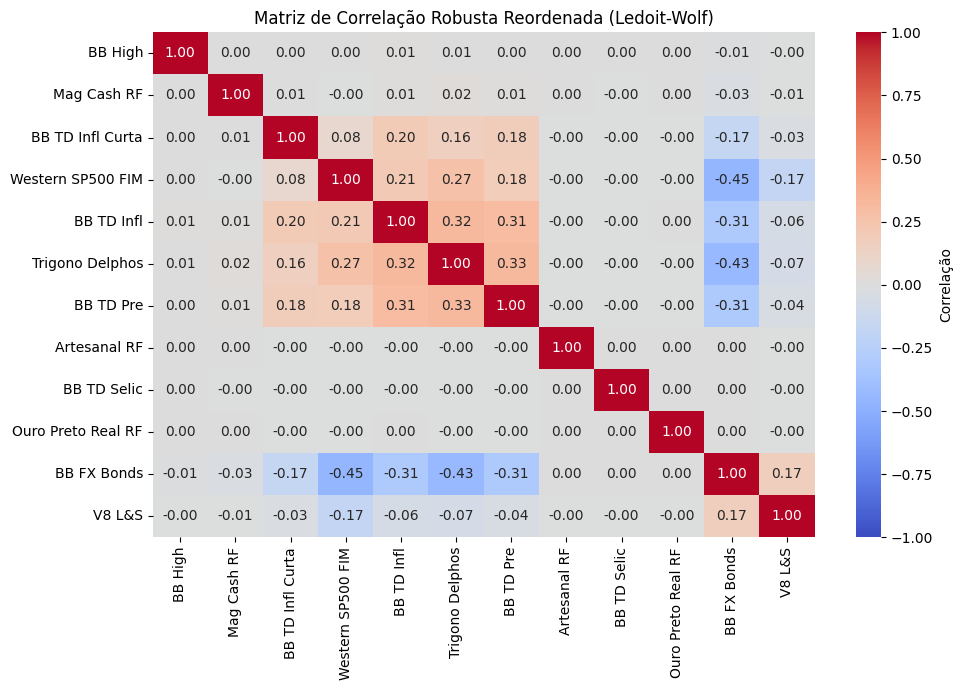

In [116]:
# Criar heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(
    corr_robusta_ord,
    annot=True,
    fmt='.2f',
    cmap='coolwarm',
    center=0,
    vmin=-1,
    vmax=1,
    # square=True,
    cbar_kws={'label': 'Correlação'}
)
plt.title('Matriz de Correlação Robusta Reordenada (Ledoit-Wolf)')
plt.tight_layout()
plt.show()

In [117]:
# Correlação
corr = retornos.corr()
# Reordenamento hierárquico 
dist = 1 - corr
link = linkage(squareform(dist), method="average")
ordem = leaves_list(link)
corr_ord = corr.iloc[ordem, ordem]


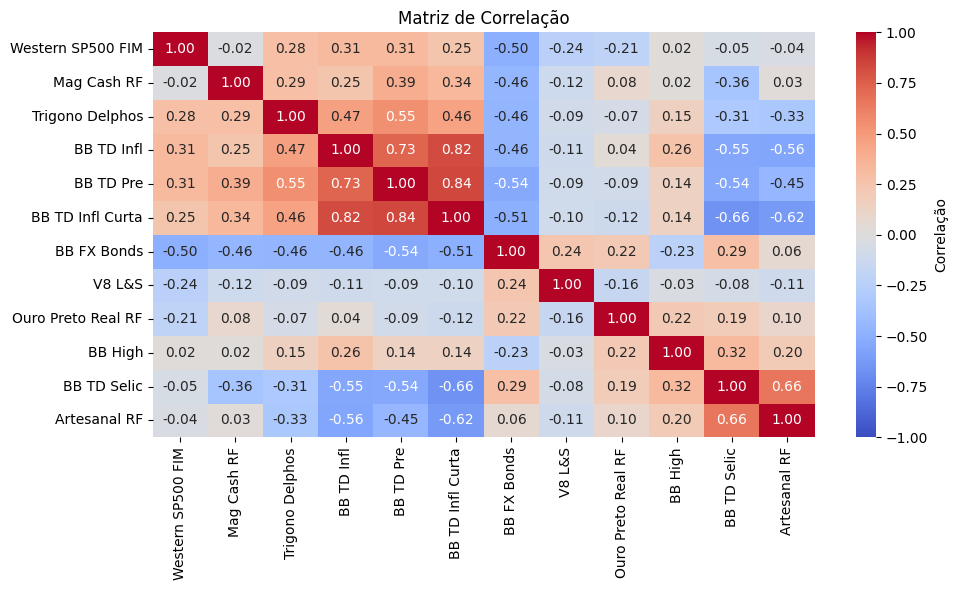

In [118]:
plt.figure(figsize=(10, 6))
sns.heatmap(
    corr_ord,
    annot=True,
    fmt='.2f',
    cmap='coolwarm',
    center=0,
    vmin=-1,
    vmax=1,
    cbar_kws={'label': 'Correlação'}
)
plt.title('Matriz de Correlação')
plt.tight_layout()
plt.show()

In [91]:
from  DT_atualiza_settings import gc

In [92]:
planilha = gc.open('Investimentos')
pagina = planilha.worksheet("Cotas-Fundos")

In [93]:
# mask = df_cotas.isin([np.inf, -np.inf]) | df_cotas.isna()
# problematic_rows = df_cotas[mask.any(axis=1)]
# print("\nProblematic rows:")
# print(problematic_rows)

In [95]:
df_cotas.insert(0, "data", df_cotas.index)
df_cotas['data']= df_cotas['data'].dt.strftime("%d/%m/%Y")
df_cotas = df_cotas.replace([np.nan, np.inf, -np.inf], '')
df_cotas

,data,Trigono Delphos,BB TD Pre,BB TD Infl,BB TD Infl Curta,BB FX Bonds,BB TD Selic,BB High,Artesanal RF,Mag Cash RF,Ouro Preto Real RF,Western SP500 FIM,V8 L&S
data,,,,,,,,,,,,,
2026-01-07,07/01/2026,2.557136,1.4768,1.318625,1.502412,1.597414,10.244005,1.933319,,2.993938,2.365627,9.820091,1.649265
2026-01-08,08/01/2026,2.55562,1.477994,1.319971,1.50314,1.602584,10.249611,1.934521,2.376894,2.995512,2.367044,9.824336,1.653523
2026-01-09,09/01/2026,2.55351,1.477161,1.317826,1.50251,1.594425,10.255175,1.935582,2.378248,2.997071,2.368421,9.89017,1.651301
2026-01-12,12/01/2026,2.554216,1.47981,1.317962,1.502975,1.59767,10.260756,1.936696,2.379595,2.998699,2.369796,9.908889,1.645514
2026-01-13,13/01/2026,2.541132,1.48075,1.317818,1.503873,1.599744,10.266361,1.93798,2.380944,3.000259,2.371168,9.890634,1.650325
2026-01-14,14/01/2026,2.547801,1.479811,1.312299,1.502391,1.60559,10.272012,1.939002,2.382298,3.001861,2.372558,9.844581,1.652482
2026-01-15,15/01/2026,2.560295,1.479567,1.313428,1.502555,1.595888,10.277658,1.940699,2.38366,3.003891,2.373956,9.87248,1.653035
2026-01-16,16/01/2026,2.541122,1.476302,1.312581,1.502229,1.598257,10.283268,1.941592,2.385019,3.005626,2.375347,9.873219,1.651281
2026-01-19,19/01/2026,2.532825,1.478151,1.312543,1.503698,1.596278,10.288843,1.942866,2.386371,3.007152,2.376727,9.873769,1.649341


In [96]:
pagina.update(
    range_name='a2', 
    values=[df_cotas.columns.values.tolist()] + df_cotas.values.tolist()
)

{'spreadsheetId': '1Mse441x9H8uByQkSTVngIKUmH5iBFwEuhGjo1LhqGE8',
 'updatedRange': "'Cotas-Fundos'!A2:M25",
 'updatedRows': 24,
 'updatedColumns': 13,
 'updatedCells': 312}